# **Data From API**

https://gdcatalog.go.th/dataset/gdpublish-fld-home/resource/1b07441a-2988-4021-8dff-47c6d695147b

In [1]:
import requests
import pandas as pd

def fetch_all_records(base_url, resource_id, limit=1000):
    all_records = []
    offset = 0

    while True:
        params = {'resource_id': resource_id, 'limit': limit, 'offset': offset}
        response = requests.get(base_url, params=params)

        if response.ok:
            records = response.json()["result"]["records"]
            all_records.extend(records)
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Error: {response.status_code}, Message: {response.text}")
            break

    return all_records

base_url = 'https://gdcatalog.go.th/api/3/action/datastore_search'
resource_id = '1b07441a-2988-4021-8dff-47c6d695147b'
dataflood = pd.DataFrame(fetch_all_records(base_url, resource_id))
dataflood

,_id,Incident Name,Disaster Date,Province Code,Province,District Code,District,Subdistrict Code,Subdistrict,Moo,...,Livestock Damage,Fishing Damage,Transport Damage,Health Damage,Culture Damage,Education/Sports,Utilities Damage,Govt. Locations Damage,Other Public Benefits,Govt Property Damage
0,1,ประเภทภัย,วันที่เกิดภัย,รหัสจังหวัด,จังหวัด,รหัสอำเภอ,อำเภอ,รหัสตำบล,ตำบล,หมู่ที่,...,ด้านปศุสัตว์\n(ตัว),ด้านประมง\n(บ่อ/กระชัง/ไร่),ด้านคมนาคม\n(แห่ง),ด้านสาธารณสุข\n(แห่ง),ด้านศาสนาวัฒนธรรม\n(แห่ง),ด้านสถานศึกษา/กีฬา\n(แห่ง),ด้านสาธารณูปโภค\n(แห่ง),ด้านสถานที่ราชการ\n(แห่ง),ด้านสาธารณประโยชน์อื่น\n(แห่ง),ด้านทรัพย์สินราชการ/เอกชน\n(หน่วย)
1,2,อุทกภัย,26/9/2023,81,กระบี่,8104,คลองท่อม,810402,คลองท่อมเหนือ,2,...,,,5,,,,,,,
2,3,อุทกภัย,14/10/2023,81,กระบี่,8108,เหนือคลอง,810805,โคกยาง,1,...,4,,7,,,,,,,
3,4,อุทกภัย,14/10/2023,81,กระบี่,8108,เหนือคลอง,810805,โคกยาง,6,...,,,,,,,,,,
4,5,อุทกภัย,4/11/2023,81,กระบี่,8101,เมืองกระบี่,810111,ทับปริก,4,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19602,19603,อุทกภัย,12/10/2023,34,อุบลราชธานี,3404,เขื่องใน,340405,หัวดอน,1,...,,,,,,,,,,
19603,19604,อุทกภัย,12/10/2023,34,อุบลราชธานี,3404,เขื่องใน,340405,หัวดอน,2,...,,,,,,,,,,
19604,19605,อุทกภัย,12/10/2023,34,อุบลราชธานี,3404,เขื่องใน,340406,ชีทวน,1,...,,,,,,,,,,
19605,19606,อุทกภัย,12/10/2023,34,อุบลราชธานี,3404,เขื่องใน,340406,ชีทวน,8,...,,,,,,,,,,


# Upload in blob starage

In [2]:
dataflood.to_csv("dataflood.csv", index=False)

In [3]:
pip install azure-storage-blob

In [4]:
!pip install azure-storage-blob

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from azure.storage.blob import BlobServiceClient
from io import BytesIO

dataflood.to_csv("dataflood.csv", index=False)

# ข้อมูลการเชื่อมต่อ Azure Storage
storage_account_name = 'kmutnbbigdata'
storage_account_key = 'itSmKCB7BmmWWkqmgf05Zhvp8tOG532lRHgLf6bZos1xkqPJKLDH7kYN+rhzNGKSlQprq/oQUXrX+AStoRvwUA=='
container_name = 'project'
csv_file_path = '/content/dataflood.csv'  # ไฟล์ CSV ในเครื่อง
parquet_blob_name = 'dataflood.parquet'  # ชื่อไฟล์ Parquet ที่จะอัพโหลด

# สร้าง BlobServiceClient เพื่อเชื่อมต่อกับ Azure Blob Storage
blob_service_client = BlobServiceClient(account_url=f"https://{storage_account_name}.blob.core.windows.net", credential=storage_account_key)
container_client = blob_service_client.get_container_client(container_name)

# Step 1: โหลดไฟล์ CSV จากเครื่อง พร้อมกับกำหนด low_memory=False เพื่อลดปัญหา DtypeWarning
df = pd.read_csv(csv_file_path, low_memory=False)

# แปลงทุกคอลัมน์ใน DataFrame ให้เป็นประเภท string
df = df.astype(str)

print("CSV file loaded and converted all columns to string type.")

# Step 2: แปลง DataFrame เป็น Parquet format ใน memory
table = pa.Table.from_pandas(df)
parquet_buffer = BytesIO()
pq.write_table(table, parquet_buffer)
parquet_buffer.seek(0)  # ย้ายตำแหน่งไปจุดเริ่มต้นของ buffer

# Step 3: อัพโหลดไฟล์ Parquet ไปยัง Azure Blob Storage
parquet_blob_client = container_client.get_blob_client(parquet_blob_name)
parquet_blob_client.upload_blob(parquet_buffer, overwrite=True)
print(f"Parquet file '{parquet_blob_name}' has been uploaded to Azure Blob Storage.")

CSV file loaded and converted all columns to string type.
Parquet file 'dataflood.parquet' has been uploaded to Azure Blob Storage.


In [5]:
parquet_blob_client = container_client.get_blob_client(parquet_blob_name)
parquet_blob_data = parquet_blob_client.download_blob().readall()

# Read the parquet file into a pyarrow table
parquet_buffer = BytesIO(parquet_blob_data)
table = pq.read_table(parquet_buffer)

print("อ่านไฟล์สำเร็จ")

อ่านไฟล์สำเร็จ


In [6]:
table.to_pandas()

,_id,Incident Name,Disaster Date,Province Code,Province,District Code,District,Subdistrict Code,Subdistrict,Moo,...,Livestock Damage,Fishing Damage,Transport Damage,Health Damage,Culture Damage,Education/Sports,Utilities Damage,Govt. Locations Damage,Other Public Benefits,Govt Property Damage
0,1,ประเภทภัย,วันที่เกิดภัย,รหัสจังหวัด,จังหวัด,รหัสอำเภอ,อำเภอ,รหัสตำบล,ตำบล,หมู่ที่,...,ด้านปศุสัตว์\n(ตัว),ด้านประมง\n(บ่อ/กระชัง/ไร่),ด้านคมนาคม\n(แห่ง),ด้านสาธารณสุข\n(แห่ง),ด้านศาสนาวัฒนธรรม\n(แห่ง),ด้านสถานศึกษา/กีฬา\n(แห่ง),ด้านสาธารณูปโภค\n(แห่ง),ด้านสถานที่ราชการ\n(แห่ง),ด้านสาธารณประโยชน์อื่น\n(แห่ง),ด้านทรัพย์สินราชการ/เอกชน\n(หน่วย)
1,2,อุทกภัย,26/9/2023,81,กระบี่,8104,คลองท่อม,810402,คลองท่อมเหนือ,2,...,,,5,,,,,,,
2,3,อุทกภัย,14/10/2023,81,กระบี่,8108,เหนือคลอง,810805,โคกยาง,1,...,4,,7,,,,,,,
3,4,อุทกภัย,14/10/2023,81,กระบี่,8108,เหนือคลอง,810805,โคกยาง,6,...,,,,,,,,,,
4,5,อุทกภัย,4/11/2023,81,กระบี่,8101,เมืองกระบี่,810111,ทับปริก,4,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19602,19603,อุทกภัย,12/10/2023,34,อุบลราชธานี,3404,เขื่องใน,340405,หัวดอน,1,...,,,,,,,,,,
19603,19604,อุทกภัย,12/10/2023,34,อุบลราชธานี,3404,เขื่องใน,340405,หัวดอน,2,...,,,,,,,,,,
19604,19605,อุทกภัย,12/10/2023,34,อุบลราชธานี,3404,เขื่องใน,340406,ชีทวน,1,...,,,,,,,,,,
19605,19606,อุทกภัย,12/10/2023,34,อุบลราชธานี,3404,เขื่องใน,340406,ชีทวน,8,...,,,,,,,,,,


# Analuyze

In [7]:
import pyarrow.dataset as ds

dataset = ds.dataset(table)
dt = dataset.to_table(columns=['Disaster Date', 'Province', 'Affected People', 'Affected Households', 'Deaths', 'Injured', 'Housing Damage', 'Business Damage', 'Agriculture Damage']).to_pandas()
dt = dt.iloc[1:]
dt

,Disaster Date,Province,Affected People,Affected Households,Deaths,Injured,Housing Damage,Business Damage,Agriculture Damage
1,26/9/2023,กระบี่,3,1,0,0,,,
2,14/10/2023,กระบี่,3,1,0,0,,,
3,14/10/2023,กระบี่,,,,,,,
4,4/11/2023,กระบี่,,,,,,,
5,4/11/2023,กระบี่,,,,,,,
...,...,...,...,...,...,...,...,...,...
19602,12/10/2023,อุบลราชธานี,,,,,,,
19603,12/10/2023,อุบลราชธานี,,,,,,,
19604,12/10/2023,อุบลราชธานี,,,,,,,
19605,12/10/2023,อุบลราชธานี,,,,,,,


In [8]:
import pandas as pd

columns_to_convert = ['Affected People', 'Affected Households', 'Deaths', 'Injured', 'Housing Damage', 'Business Damage', 'Agriculture Damage']

for col in columns_to_convert:
    dt[col] = pd.to_numeric(dt[col], errors='coerce').fillna(0).astype(int)

print(dt.dtypes)

Disaster Date          object
Province               object
Affected People         int64
Affected Households     int64
Deaths                  int64
Injured                 int64
Housing Damage          int64
Business Damage         int64
Agriculture Damage      int64
dtype: object


In [9]:
dt

,Disaster Date,Province,Affected People,Affected Households,Deaths,Injured,Housing Damage,Business Damage,Agriculture Damage
1,26/9/2023,กระบี่,3,1,0,0,0,0,0
2,14/10/2023,กระบี่,3,1,0,0,0,0,0
3,14/10/2023,กระบี่,0,0,0,0,0,0,0
4,4/11/2023,กระบี่,0,0,0,0,0,0,0
5,4/11/2023,กระบี่,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
19602,12/10/2023,อุบลราชธานี,0,0,0,0,0,0,0
19603,12/10/2023,อุบลราชธานี,0,0,0,0,0,0,0
19604,12/10/2023,อุบลราชธานี,0,0,0,0,0,0,0
19605,12/10/2023,อุบลราชธานี,0,0,0,0,0,0,0


In [32]:
columns_to_sum = ['Affected People', 'Affected Households', 'Deaths', 'Injured', 'Housing Damage', 'Business Damage', 'Agriculture Damage']
data_date = dt.groupby(['Disaster Date', 'Province'], as_index=False)[columns_to_sum].sum()
data_date['Total Damage'] = data_date[columns_to_sum].sum(axis=1)
data_date

,Disaster Date,Province,Affected People,Affected Households,Deaths,Injured,Housing Damage,Business Damage,Agriculture Damage,Total Damage
0,1/10/2023,ขอนแก่น,128,33,0,0,0,0,0,161
1,1/10/2023,ฉะเชิงเทรา,0,0,0,0,0,0,0,0
2,1/10/2023,ตาก,0,0,0,0,0,0,0,0
3,1/10/2023,นครปฐม,792,264,0,0,0,0,0,1056
4,1/10/2023,นครสวรรค์,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
749,9/9/2023,มุกดาหาร,166,13,0,0,0,0,443,622
750,9/9/2023,ร้อยเอ็ด,231,71,0,0,0,0,3431,3733
751,9/9/2023,ลำปาง,105,35,0,0,0,0,0,140
752,9/9/2023,เชียงราย,300,100,0,0,0,0,0,400


In [33]:
# ติดตั้งไลบรารี deep-translator
!pip install deep-translator

from deep_translator import GoogleTranslator
import pandas as pd

# แปลชื่อจังหวัดในแต่ละแถว
def translate_province_names(column):
    return column.apply(lambda x: GoogleTranslator(source='th', target='en').translate(x))

# แปลง DataFrame
data_date['Province'] = translate_province_names(data_date['Province'])

# แสดงผลลัพธ์
print(data_date)

    Disaster Date       Province  Affected People  Affected Households  \
0       1/10/2023      Khon Kaen              128                   33   
1       1/10/2023   Chachoengsao                0                    0   
2       1/10/2023            dry                0                    0   
3       1/10/2023  Nakhon Pathom              792                  264   
4       1/10/2023   Nakhon Sawan                0                    0   
..            ...            ...              ...                  ...   
749      9/9/2023       Mukdahan              166                   13   
750      9/9/2023         Roi Et              231                   71   
751      9/9/2023        Lampang              105                   35   
752      9/9/2023     Chiang Rai              300                  100   
753      9/9/2023     Chiang Mai            28765                 9642   

     Deaths  Injured  Housing Damage  Business Damage  Agriculture Damage  \
0         0        0              

In [34]:
data_date

,Disaster Date,Province,Affected People,Affected Households,Deaths,Injured,Housing Damage,Business Damage,Agriculture Damage,Total Damage
0,1/10/2023,Khon Kaen,128,33,0,0,0,0,0,161
1,1/10/2023,Chachoengsao,0,0,0,0,0,0,0,0
2,1/10/2023,dry,0,0,0,0,0,0,0,0
3,1/10/2023,Nakhon Pathom,792,264,0,0,0,0,0,1056
4,1/10/2023,Nakhon Sawan,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
749,9/9/2023,Mukdahan,166,13,0,0,0,0,443,622
750,9/9/2023,Roi Et,231,71,0,0,0,0,3431,3733
751,9/9/2023,Lampang,105,35,0,0,0,0,0,140
752,9/9/2023,Chiang Rai,300,100,0,0,0,0,0,400


In [37]:
data_date.to_csv("dataflood_new.csv", index=False)

In [41]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from azure.storage.blob import BlobServiceClient
from io import BytesIO

# ข้อมูลการเชื่อมต่อ Azure Storage
storage_account_name = 'kmutnbbigdata'
storage_account_key = 'itSmKCB7BmmWWkqmgf05Zhvp8tOG532lRHgLf6bZos1xkqPJKLDH7kYN+rhzNGKSlQprq/oQUXrX+AStoRvwUA=='
container_name = 'project'
csv_blob_name = 'dataflood_new.csv'  # แก้ไขชื่อไฟล์ CSV ที่จะอัพโหลด

# สร้าง BlobServiceClient เพื่อเชื่อมต่อกับ Azure Blob Storage
blob_service_client = BlobServiceClient(account_url=f"https://{storage_account_name}.blob.core.windows.net", credential=storage_account_key)
container_client = blob_service_client.get_container_client(container_name)

# แปลง DataFrame เป็น CSV format ใน memory
csv_buffer = BytesIO()
data_date.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)  # ย้ายตำแหน่งไปจุดเริ่มต้นของ buffer

# อัพโหลดไฟล์ CSV ไปยัง Azure Blob Storage
csv_blob_client = container_client.get_blob_client(csv_blob_name)
csv_blob_client.upload_blob(csv_buffer.getvalue(), overwrite=True)
print(f"CSV file '{csv_blob_name}' has been uploaded to Azure Blob Storage.")

CSV file 'dataflood_new.csv' has been uploaded to Azure Blob Storage.


# Power Bi

In [43]:
# เลือกข้อมูล 10 อันดับสูงสุดของวันเวลาที่เกิดเหตุตาม Total Damage
top_10_data = data_date.nlargest(10, 'Total Damage')
top_10_data

,Disaster Date,Province,Affected People,Affected Households,Deaths,Injured,Housing Damage,Business Damage,Agriculture Damage,Total Damage
33,1/9/2023,Yasothon,24,8,0,0,0,0,127197,127229
373,24/12/2023,Narathiwat,99172,25649,6,0,0,0,0,124827
362,23/12/2023,Narathiwat,86177,23304,0,0,344,0,0,109825
284,19/9/2023,Sukhothai,10529,3587,0,0,77,2,44935,59130
428,26/9/2023,Sukhothai,8607,5019,0,0,0,0,39312,52938
133,14/12/2023,Narathiwat,39902,9523,7,0,1683,0,0,51115
585,30/9/2023,Sukhothai,9437,5282,1,0,1749,0,31876,48345
753,9/9/2023,Chiang Mai,28765,9642,0,0,0,0,800,39207
675,6/8/2023,Chiang Rai,28407,9469,0,0,0,0,0,37876
288,2/10/2023,Khon Kaen,9,3,0,0,7,0,35813,35832


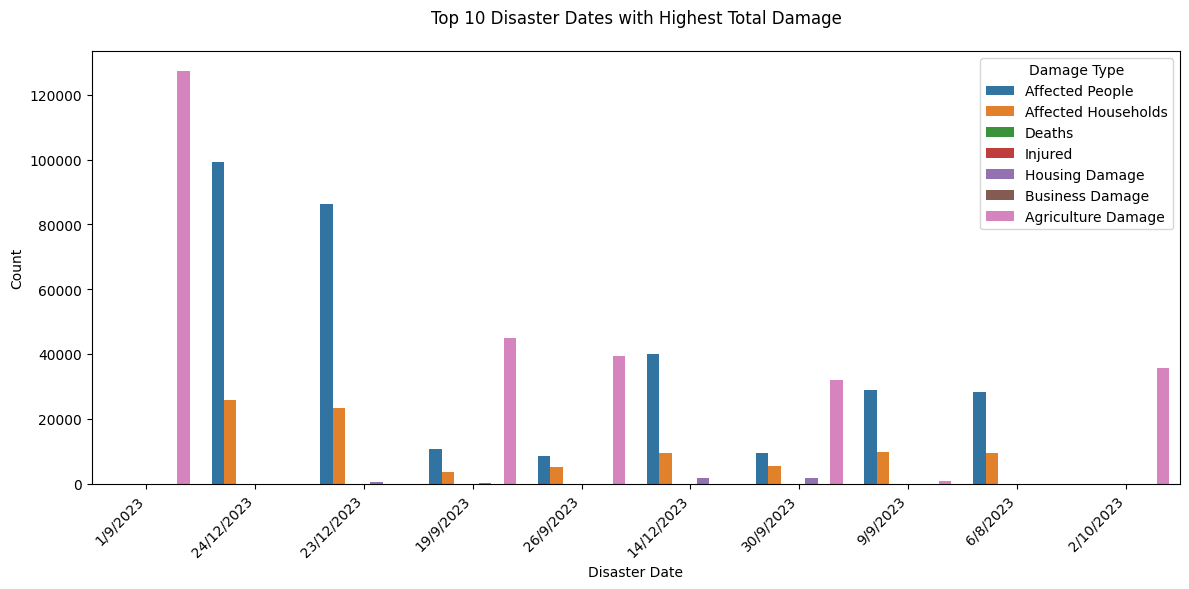

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# แปลงข้อมูลเพื่อให้เหมาะสำหรับการสร้างกราฟ
data_melted = top_10_data.melt(id_vars='Disaster Date',
                                 value_vars=['Affected People', 'Affected Households', 'Deaths',
                                             'Injured', 'Housing Damage', 'Business Damage',
                                             'Agriculture Damage'],
                                 var_name='Damage Type',
                                 value_name='Count')

# กำหนดรูปแบบกราฟ
plt.figure(figsize=(12, 6))

# สร้างกราฟแท่ง โดยปรับขนาดของแท่งให้มีระยะห่าง
barplot = sns.barplot(data=data_melted, x='Disaster Date', y='Count', hue='Damage Type')

# ปรับแต่งกราฟ
plt.title('Top 10 Disaster Dates with Highest Total Damage', pad=20)  # เพิ่มระยะห่างจาก title
plt.xlabel('Disaster Date')
plt.ylabel('Count')
plt.xticks(rotation=45)

# เพิ่มระยะห่างระหว่างช่วงเวลา
for item in barplot.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment('right')

plt.legend(title='Damage Type')
plt.tight_layout()

# แสดงกราฟ
plt.show()

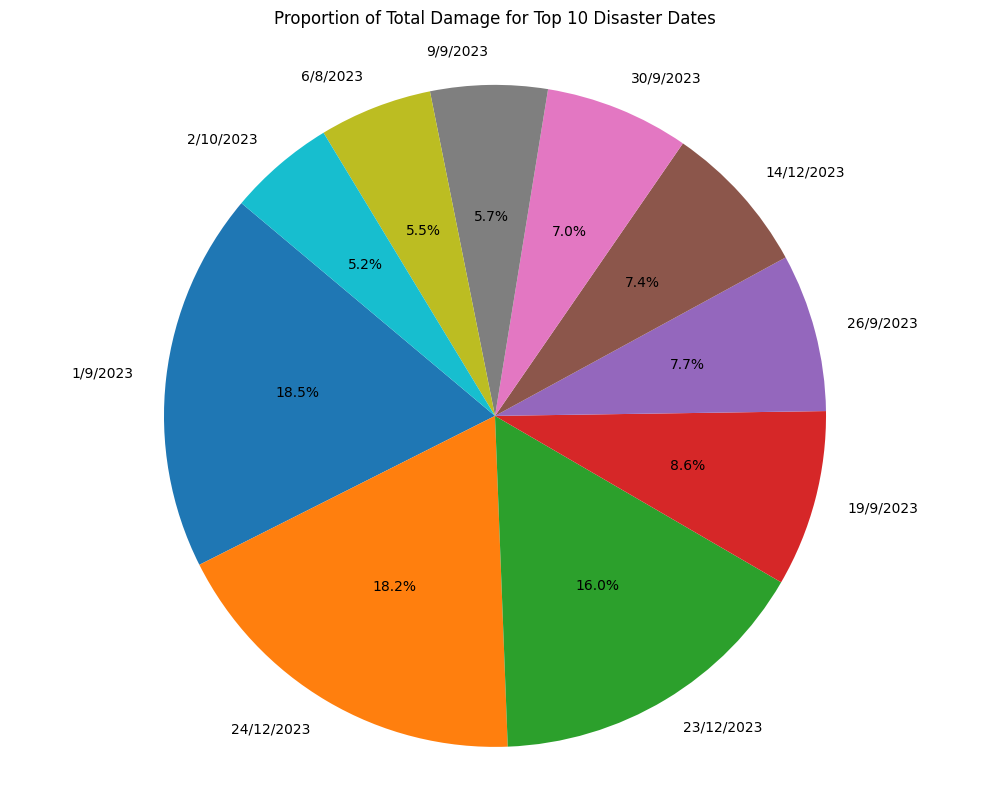

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# กำหนดรูปแบบกราฟ
plt.figure(figsize=(10, 8))

# สร้างกราฟวงกลมสำหรับ Total Damage
plt.pie(top_10_data['Total Damage'], labels=top_10_data['Disaster Date'], autopct='%1.1f%%', startangle=140)

# ปรับแต่งกราฟ
plt.title('Proportion of Total Damage for Top 10 Disaster Dates', pad=20)  # เพิ่มระยะห่างจาก title
plt.axis('equal')  # ทำให้กราฟเป็นวงกลม
plt.tight_layout()

# แสดงกราฟ
plt.show()

In [46]:
# เลือกข้อมูล 10 อันดับสูงสุดของจังหวัดตาม Total Damage
top_10_data2 = data_province_translated.nlargest(10, 'Total Damage')
top_10_data2

,Province,Disaster Date,Affected People,Affected Households,Deaths,Injured,Housing Damage,Business Damage,Agriculture Damage,Total Damage
399,ยโสธร,1/9/2023,24,8,0,0,0,0,127197,127229
271,นราธิวาส,24/12/2023,99172,25649,6,0,0,0,0,124827
270,นราธิวาส,23/12/2023,86177,23304,0,0,344,0,0,109825
538,สุโขทัย,19/9/2023,10529,3587,0,0,77,2,44935,59130
544,สุโขทัย,26/9/2023,8607,5019,0,0,0,0,39312,52938
264,นราธิวาส,14/12/2023,39902,9523,7,0,1683,0,0,51115
547,สุโขทัย,30/9/2023,9437,5282,1,0,1749,0,31876,48345
720,เชียงใหม่,9/9/2023,28765,9642,0,0,0,0,800,39207
655,เชียงราย,6/8/2023,28407,9469,0,0,0,0,0,37876
75,ขอนแก่น,2/10/2023,9,3,0,0,7,0,35813,35832


<ipython-input-47-fd916ec776e4>:27: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from current font.
  plt.tight_layout()
<ipython-input-47-fd916ec776e4>:27: UserWarning: Glyph 3650 (\N{THAI CHARACTER SARA O}) missing from current font.
  plt.tight_layout()
<ipython-input-47-fd916ec776e4>:27: UserWarning: Glyph 3626 (\N{THAI CHARACTER SO SUA}) missing from current font.
  plt.tight_layout()
<ipython-input-47-fd916ec776e4>:27: UserWarning: Glyph 3608 (\N{THAI CHARACTER THO THONG}) missing from current font.
  plt.tight_layout()
<ipython-input-47-fd916ec776e4>:27: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from current font.
  plt.tight_layout()
<ipython-input-47-fd916ec776e4>:27: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from current font.
  plt.tight_layout()
<ipython-input-47-fd916ec776e4>:27: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from current font.
  plt.tight_layout()
<ipython-input-47-fd916ec776e4>:27: UserWarni

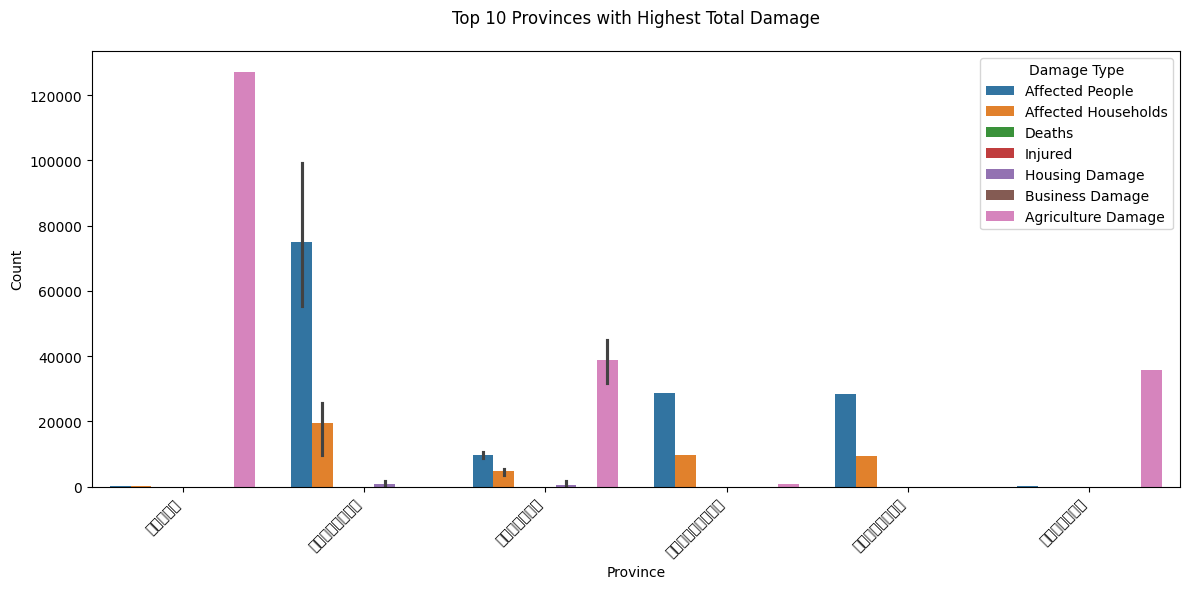

In [47]:
# แปลงข้อมูลเพื่อให้เหมาะสำหรับการสร้างกราฟ
data_melted = top_10_data2.melt(id_vars='Province',
                                 value_vars=['Affected People', 'Affected Households', 'Deaths',
                                             'Injured', 'Housing Damage', 'Business Damage',
                                             'Agriculture Damage'],
                                 var_name='Damage Type',
                                 value_name='Count')

# กำหนดรูปแบบกราฟ
plt.figure(figsize=(12, 6))

# สร้างกราฟแท่ง โดยปรับขนาดของแท่งให้มีระยะห่าง
barplot = sns.barplot(data=data_melted, x='Province', y='Count', hue='Damage Type')

# ปรับแต่งกราฟ
plt.title('Top 10 Provinces with Highest Total Damage', pad=20)
plt.xlabel('Province')
plt.ylabel('Count')
plt.xticks(rotation=45)

# เพิ่มระยะห่างระหว่างช่วงเวลา
for item in barplot.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment('right')

plt.legend(title='Damage Type')
plt.tight_layout()

# แสดงกราฟ
plt.show()

In [49]:
import folium

# กำหนดตำแหน่งของจังหวัดที่มีความเสียหายสูงสุด
provinces = {
    'Chiang Mai': [18.7883, 98.9853],
    'Narathiwat': [6.4260, 101.8239],
    'Sukhothai': [17.0071, 99.8224],
    'Kalasin': [16.4420, 102.4070],
    'Yasothon': [15.7710, 104.1675],
    'Sakon Nakhon': [17.1555, 104.1406],
    'Nakhon Phanom': [17.4751, 104.7493],
    'Roi Et': [16.0700, 103.6452],
    'Maha Sarakham': [16.1818, 103.2912],
    'Khon Kaen': [16.4419, 102.8356]
}

# สร้างแผนที่เริ่มต้น
map_provinces = folium.Map(location=[15.8700, 100.9925], zoom_start=6)

# เพิ่มจุดจังหวัดที่มีความเสียหายสูงสุดลงในแผนที่
for idx, province in enumerate(top_10_data2['Province']):
    damage = top_10_data2[top_10_data2['Province'] == province]['Total Damage'].values[0]
    coords = provinces[province]

    # สร้าง Marker พร้อมตัวเลขลำดับ
    folium.Marker(
        location=coords,
        popup=f"{province}: {damage:,}",  # แสดงจังหวัดและจำนวนความเสียหายใน popup
        icon=folium.DivIcon(
            html=f'''
                <div style="font-size: 12pt; color: blue;
                            background-color: white;
                            border-radius: 50%;
                            padding: 10px;
                            text-align: center;
                            border: 2px solid blue;
                            width: 30px;
                            height: 30px;
                            display: flex;
                            align-items: center;
                            justify-content: center;">
                    {idx + 1}  <!-- แสดงลำดับ -->
                </div>
            '''
        )
    ).add_to(map_provinces)

# แสดงแผนที่
map_provinces

KeyError: 'ยโสธร'